<a href="https://colab.research.google.com/github/ranton256/classifying_concord/blob/main/supervised_ML_identify_author.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Machine Learning - Identify Author


In [1]:
%pip install -q spacy

In [2]:
# you will need to download the spacy model for english.
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 130.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
# %pip install -r requirements.txt

In [4]:
import spacy

## The Dataset
Our two datasets are constructed from two related works of 19th century American transcendentalism. These are both public domain.

1. [Essays by Ralph Waldo Emerson by Ralph Waldo Emerson](https://www.google.com/url?q=https%3A%2F%2Fwww.gutenberg.org%2Febooks%2F16643)
2. [Walden, and On The Duty Of Civil Disobedience by Henry David Thoreau](https://www.google.com/url?q=https%3A%2F%2Fwww.gutenberg.org%2Febooks%2F205)

These two authors had different writing styles but shared more than their philosophical interests—they were neighbors in Concord, Massachusetts.

These two works are also similar in length when formatted as plain text.

We will use spaCy to segment each work into sections of roughly 3 to 5 sentences each, then build a datafrom of the text including a label of 'emerson' or 'thoreau', then shuffle and split that into train and test sets for training some machine learning models to classify them by predicting which author they are from and compare the results.

We will also preprocess text to remove stopwords,and perform lemmatization.

In [5]:
emerson_txt_url = "https://www.gutenberg.org/ebooks/16643.txt.utf-8"
thoreau_txt_url = "https://www.gutenberg.org/ebooks/205.txt.utf-8"


In [6]:
import requests
from pathlib import Path

In [7]:
def download_file(url):
  local_filename = Path(url.split('/')[-1])
  result = requests.get(url)
  result.raise_for_status()
  with open(local_filename, "wb") as f:
      f.write(result.content)
  return local_filename

In [8]:
emerson_file = download_file(emerson_txt_url)
thoreau_file = download_file(thoreau_txt_url)

In [9]:
!head -n 50 {emerson_file}

The Project Gutenberg eBook of Essays by Ralph Waldo Emerson
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. If you are not located in the United States,
you will have to check the laws of the country where you are located
before using this eBook.

Title: Essays by Ralph Waldo Emerson

Author: Ralph Waldo Emerson

Editor: Edna Henry Lee Turpin

Release date: September 4, 2005 [eBook #16643]
                Most recently updated: April 29, 2022

Language: English

Credits: Curtis A. Weyant, Sankar Viswanathan and the Online Distributed Proofreading Team


*** START OF THE PROJECT GUTENBERG EBOOK ESSAYS BY RALPH WALDO EMERSON ***




                                ESSAYS

                                  BY

                     

In [10]:
!head -n 50 {thoreau_file}

The Project Gutenberg eBook of Walden, and On The Duty Of Civil Disobedience
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. If you are not located in the United States,
you will have to check the laws of the country where you are located
before using this eBook.

Title: Walden, and On The Duty Of Civil Disobedience

Author: Henry David Thoreau

Release date: January 1, 1995 [eBook #205]
                Most recently updated: September 19, 2024

Language: English

Credits: Judith Boss, and David Widger


*** START OF THE PROJECT GUTENBERG EBOOK WALDEN, AND ON THE DUTY OF CIVIL DISOBEDIENCE ***
WALDEN




and



ON THE DUTY OF CIVIL DISOBEDIENCE



by Henry David Thoreau


cover


Contents


 WALDEN

 Economy
 Where I Lived, and W

In [11]:
# Let's strip the frontmatter lines off the start of each file.
# remove each line preceding one that contains "START OF THE PROJECT GUTENBERG EBOOK "
!grep -n "START OF THE PROJECT GUTENBERG EBOOK" {emerson_file}
!grep -n "START OF THE PROJECT GUTENBERG EBOOK" {thoreau_file}

25:*** START OF THE PROJECT GUTENBERG EBOOK ESSAYS BY RALPH WALDO EMERSON ***
23:*** START OF THE PROJECT GUTENBERG EBOOK WALDEN, AND ON THE DUTY OF CIVIL DISOBEDIENCE ***


In [12]:
def trim_frontmatter(filename):
  with open(filename) as f:
    lines = f.readlines()

  n_trim_lines = 0
  for i, line in enumerate(lines):
    if "START OF THE PROJECT GUTENBERG EBOOK" in line:
      n_trim_lines = i + 1
      break

  trimmed_lines = lines[n_trim_lines:]
  trimmed_content = '\n'.join(trimmed_lines)
  new_filename = f"trimmed_{filename}"
  with open(new_filename, "w") as f:
    f.write(trimmed_content)
  return new_filename

In [13]:
trimmed_emerson_file = trim_frontmatter(emerson_file)
trimmed_thoreau_file = trim_frontmatter(thoreau_file)

In [14]:
!head {trimmed_emerson_file}
!head {trimmed_thoreau_file}









                                ESSAYS

WALDEN











In [15]:
from collections import deque
from random import randint
import itertools


In [16]:
nlp = spacy.load("en_core_web_sm")
# if you have an error here, make sure you ran the "!python -m spacy download en_core_web_sm" command in the earlier cell.

In [17]:
def segment_doc(filename):
  with open(filename) as f:
    text = f.read()
  doc = nlp(text)
  assert doc.has_annotation("SENT_START")

  sent_dq = deque()
  #it = doc.sents.__iter__()
  n = randint(3, 5)

  for sent in doc.sents:
    sent_dq.append(sent)
    if len(sent_dq) > n:
      sent_dq.popleft()
      snippet = " ".join(sent.text for sent in sent_dq)
      yield snippet
      n = randint(3, 5)
      sent_dq.clear()

In [18]:
import pandas as pd

In [19]:
def dataframe_from_file(file_path):
  segments = segment_doc(file_path)

  df = pd.DataFrame(segments, columns=["text"])
  return df


In [20]:
emerson_df = dataframe_from_file(trimmed_emerson_file)
emerson_df.to_csv("emerson.csv")
emerson_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1065 entries, 0 to 1064
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1065 non-null   object
dtypes: object(1)
memory usage: 8.4+ KB


In [21]:
emerson_df.head()

,text
0,The editors of the several volumes will be\n\n...
1,He entered Harvard\n\nat the early age of four...
2,After graduating from college he taught school...
3,His talent seems to have been in\n\ngiving new...
4,"To tell the truth, in my\n\nopinion, that youn..."


In [22]:

thoreau_df = dataframe_from_file(trimmed_thoreau_file)
thoreau_df.to_csv("thoreau.csv")
thoreau_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847 entries, 0 to 846
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    847 non-null    object
dtypes: object(1)
memory usage: 6.7+ KB


In [23]:
thoreau_df.head()

,text
0,I lived there two\n\nyears and two months. At ...
1,Others have been\n\ncurious to learn what port...
2,"Moreover, I, on my side, require of every writ..."
3,I have travelled a good deal in Concord;\n\nan...
4,Who made them\n\nserfs of the soil? Why should...


In [24]:
# combine and shuffle the datasets, using a consistent random seed.
from sklearn.utils import shuffle

d1 = emerson_df.copy()
d1["label"] = "emerson"

d2 = thoreau_df.copy()
d2["label"] = "thoreau"

combined_df = pd.concat([d1, d2])
combined_df = shuffle(combined_df, random_state=7919)
combined_df.to_csv("combined.csv")
combined_df.info()
combined_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1912 entries, 153 to 77
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1912 non-null   object
 1   label   1912 non-null   object
dtypes: object(2)
memory usage: 44.8+ KB


,text,label
153,I also dreamed that I might\n\ngather the wild...,thoreau
638,"You admire this tower of granite, weathering t...",emerson
685,The grass flames up on the\n\nhillsides like a...,thoreau
409,"Money is not\n\nessential, but this wide affin...",emerson
38,“What!”\n\nexclaimed the Indian as he went out...,thoreau


## Now we have our dataset in combined.csv


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
# you can start here if csv files were already created.
from sklearn.feature_extraction.text import TfidfVectorizer

<ipython-input-27-3711010374>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=combined_df["label"], palette="rocket")


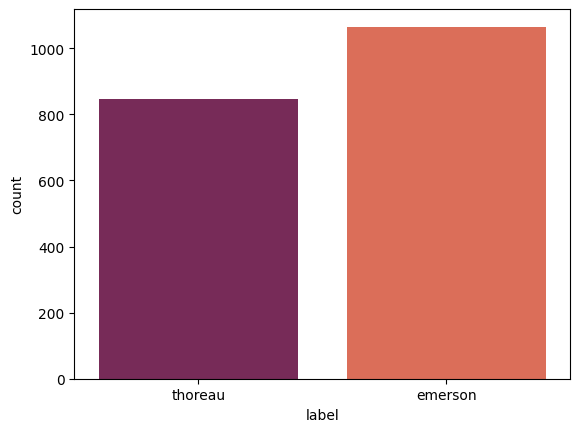

In [27]:
sns.countplot(x=combined_df["label"], palette="rocket")
plt.show()


In [28]:
%pip install -q wordcloud

In [29]:
from spacy.lang.en import STOP_WORDS
my_stopwords = STOP_WORDS

', '.join(my_stopwords)

"with, various, once, we, each, never, there, 'd, beforehand, 're, he, throughout, an, whose, if, towards, empty, somewhere, moreover, between, ‘ll, but, amongst, whom, three, 've, both, thereby, one, about, becoming, us, latterly, hers, n‘t, together, hence, enough, within, say, against, anything, for, been, whenever, side, i, top, after, not, whatever, yet, least, too, off, besides, your, afterwards, ’ll, just, often, less, further, had, whither, do, toward, sometime, anyone, call, full, thru, only, behind, some, ours, ever, above, all, other, itself, nine, none, most, ‘d, again, front, beside, wherever, became, in, done, would, same, six, give, ‘re, very, yourself, seem, have, on, than, though, below, my, to, everyone, mine, a, hundred, thus, hereby, at, might, those, put, such, go, into, amount, it, therefore, already, should, ’m, herself, around, seeming, become, others, has, mostly, during, over, nothing, re, under, here, really, will, twelve, being, down, from, ten, without, now

In [30]:
# Show wordcloud from each dataset.
from wordcloud import WordCloud


def plot_word_cloud(text_sections, title):
  cloud = WordCloud(background_color='black', stopwords=my_stopwords).generate(str(text_sections))
  fig = plt.figure(figsize=(12,8), facecolor='white')
  plt.imshow(cloud, interpolation="bilinear")
  plt.axis('off')
  plt.title(title, fontsize=48)
  plt.tight_layout(pad=0)
  plt.show()




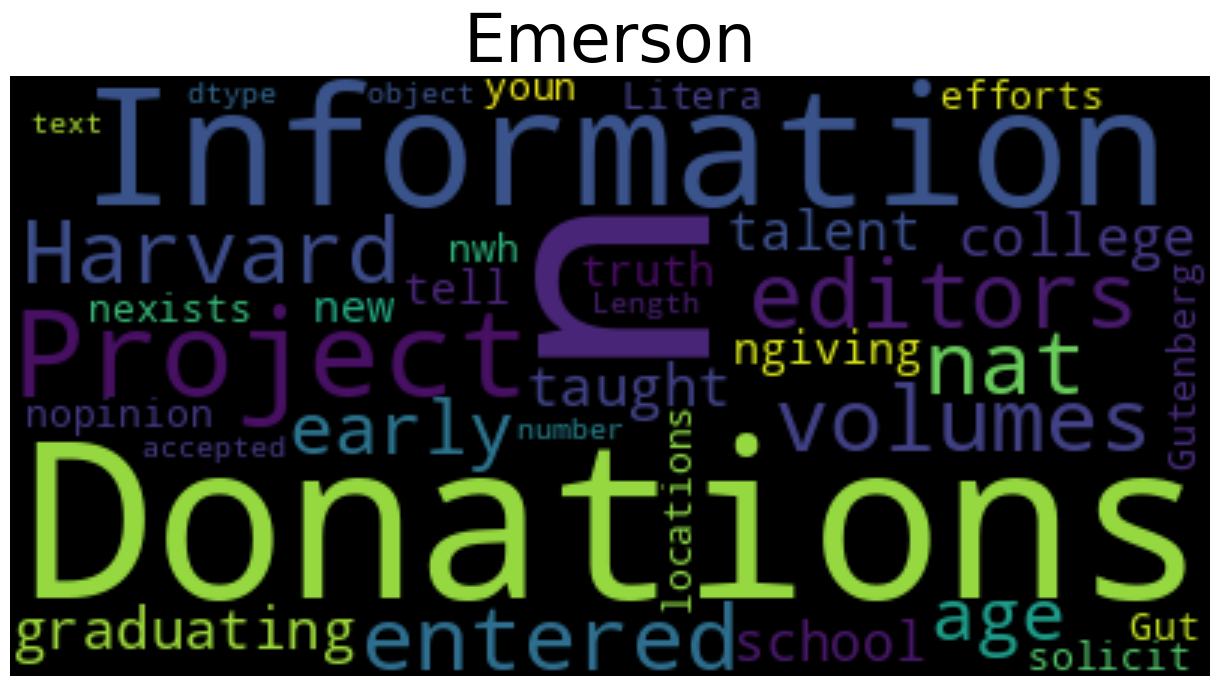

In [31]:
plot_word_cloud(emerson_df["text"], "Emerson")

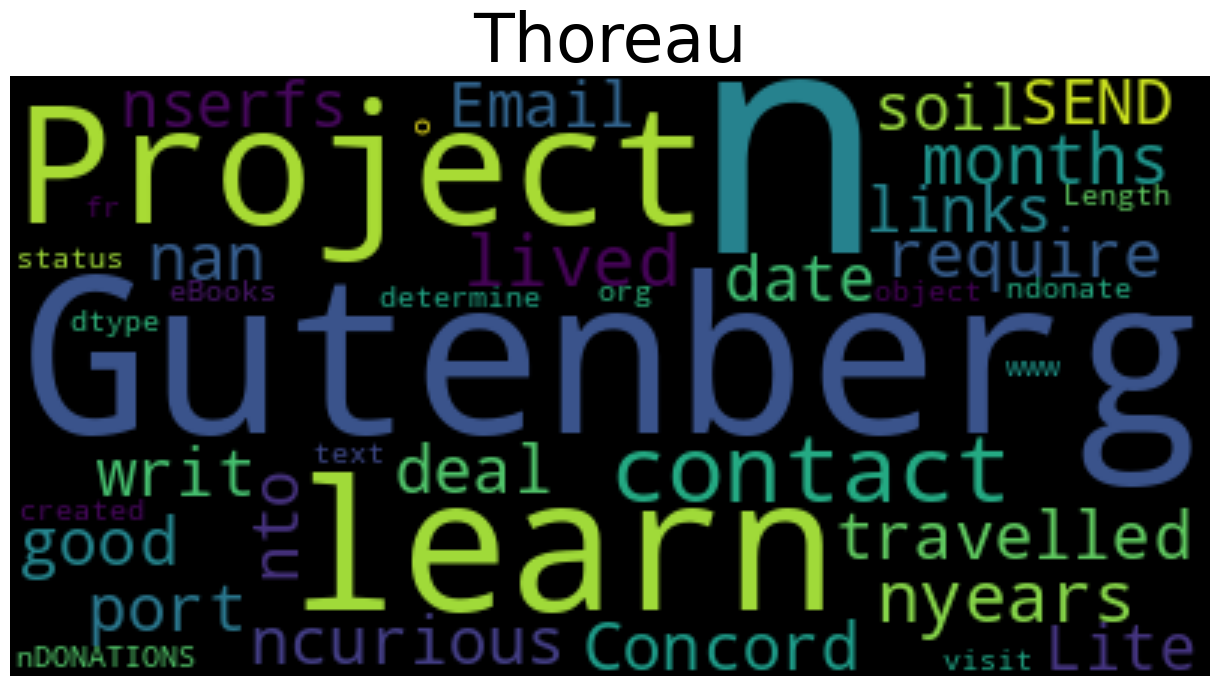

In [32]:
plot_word_cloud(thoreau_df["text"], "Thoreau")

## Traditional (Non-Transformer) Models

In [33]:
# Preprocess text to remove stopwords, and perform lemmatization.

final_text = []
for index,entry in enumerate(combined_df['text']):
  doc = nlp(entry.lower())
  Final_words = []
  for word in doc:
    if not word.is_stop and not word.is_punct:
      Final_words.append(word.lemma_)
  final_text.append(' '.join(Final_words))



In [34]:
combined_df['final_text'] = final_text
combined_df.head()

,text,label,final_text
153,I also dreamed that I might\n\ngather the wild...,thoreau,dream \n\n gather wild herb carry evergreen vi...
638,"You admire this tower of granite, weathering t...",emerson,admire tower granite weather hurt \n\n age lit...
685,The grass flames up on the\n\nhillsides like a...,thoreau,"grass flame \n\n hillside like spring fire,—“e..."
409,"Money is not\n\nessential, but this wide affin...",emerson,money \n\n essential wide affinity transcend h...
38,“What!”\n\nexclaimed the Indian as he went out...,thoreau,\n\n exclaim indian go gate mean starve \n\n h...


In [35]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(combined_df["final_text"])
y = combined_df["label"]


In [36]:
# split our data into train and test sets.
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4909)
print(f"x_train: {x_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"x_test: {x_test.shape}")
print(f"y_test: {y_test.shape}")

x_train: (1529, 11890)
y_train: (1529,)
x_test: (383, 11890)
y_test: (383,)


In [37]:
from sklearn.linear_model import LogisticRegression


In [38]:
# -2 for n_jobs is all but one CPU available.
lr_model = LogisticRegression(solver='saga', random_state=8102, n_jobs=-2)

lr_model.fit(x_train, y_train)

LogisticRegression(n_jobs=-2, random_state=8102, solver='saga')

In [39]:
y_pred = lr_model.predict(x_test)

In [40]:
from sklearn.metrics import f1_score

In [41]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from IPython.display import Markdown, display

def show_metrics(y_test, y_pred, model_name):
  display(Markdown(f"# {model_name}"))

  print(classification_report(y_test,y_pred))
  print("Test accuracy:", accuracy_score(y_test,y_pred))
  cm = confusion_matrix(y_test, y_pred)

  labels = ["emerson", "thoreau"]
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
  plt.title('Confusion Matrix')
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()

# Logistic Regression

              precision    recall  f1-score   support

     emerson       0.81      0.94      0.87       205
     thoreau       0.91      0.74      0.82       178

    accuracy                           0.85       383
   macro avg       0.86      0.84      0.84       383
weighted avg       0.85      0.85      0.84       383

Test accuracy: 0.8459530026109661


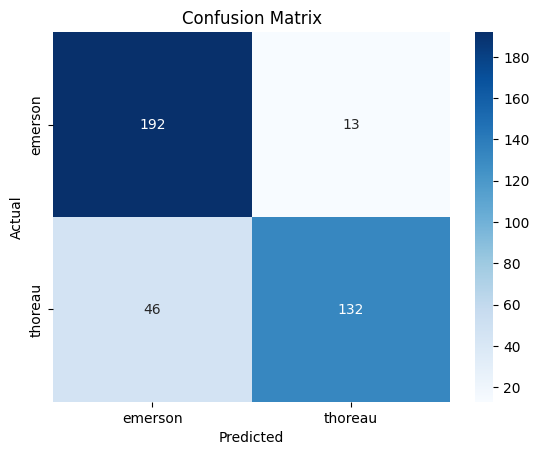

In [42]:
show_metrics(y_test, y_pred, "Logistic Regression")

In [43]:
# Let's compare that to random forests.


from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(x_train,y_train)


RandomForestClassifier()

In [44]:
y_pred_rf = rf.predict(x_test)

# Random Forest

              precision    recall  f1-score   support

     emerson       0.78      0.89      0.83       205
     thoreau       0.85      0.72      0.78       178

    accuracy                           0.81       383
   macro avg       0.82      0.80      0.81       383
weighted avg       0.81      0.81      0.81       383

Test accuracy: 0.8093994778067886


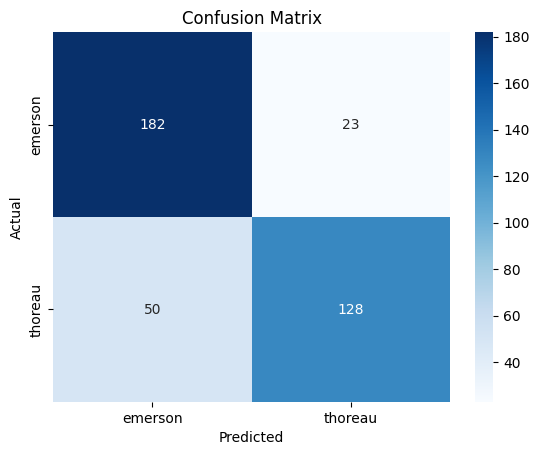

In [45]:
show_metrics(y_test, y_pred_rf, "Random Forest")

In [46]:
from sklearn import svm

In [47]:
# create the SVM classifier
clf = svm.SVC(kernel='rbf')

clf.fit(x_train,y_train)
clf

SVC()

In [48]:
y_pred_svm = clf.predict(x_test)

# SVM

              precision    recall  f1-score   support

     emerson       0.82      0.93      0.87       205
     thoreau       0.90      0.77      0.83       178

    accuracy                           0.85       383
   macro avg       0.86      0.85      0.85       383
weighted avg       0.86      0.85      0.85       383

Test accuracy: 0.8537859007832899


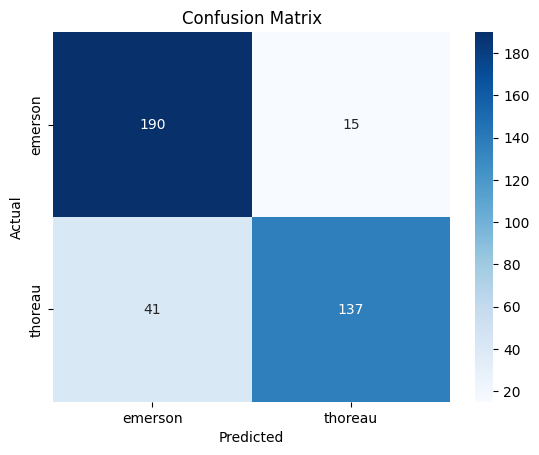

In [49]:
show_metrics(y_test, y_pred_svm, "SVM")

In [50]:
# if not colab
#%pip install -q transformers
#%pip install -q torch

In [51]:
import torch

In [52]:
from transformers import AutoTokenizer, AutoModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [53]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", return_token_type_ids = False, padding="max_length", truncation=True)

model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)


In [54]:
x_train_s, x_test_s, y_train_s, y_test_s = train_test_split(combined_df["text"], combined_df["label"], test_size=0.2, random_state=4909)
print(f"x_train_s: {x_train_s.shape}")
print(f"y_train_s: {y_train_s.shape}")
print(f"x_test_s: {x_test_s.shape}")
print(f"y_test_s: {y_test_s.shape}")


x_train_s: (1529,)
y_train_s: (1529,)
x_test_s: (383,)
y_test_s: (383,)


In [55]:
x_train_tok = tokenizer(x_train_s.tolist(), padding=True, truncation=True, return_tensors="pt")
y_train_tok = y_train_s.tolist()

x_test_tok = tokenizer(x_test_s.tolist(), padding=True, truncation=True, return_tensors="pt")
y_test_tok = y_test_s.tolist()


In [56]:
x_train_tok[0:2]

[Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]),
 Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])]

In [57]:

print(x_train_tok.keys())


#move onto device (GPU)
x_train_tok = {k:torch.tensor(v).to(device) for k,v in x_train_tok.items()}
x_test_tok = {k:torch.tensor(v).to(device) for k,v in x_test_tok.items()}

dict_keys(['input_ids', 'attention_mask'])


<ipython-input-57-3140837852>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tok = {k:torch.tensor(v).to(device) for k,v in x_train_tok.items()}
<ipython-input-57-3140837852>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tok = {k:torch.tensor(v).to(device) for k,v in x_test_tok.items()}


In [58]:
with torch.no_grad():
  hidden_train = model(**x_train_tok)
  hidden_test = model(**x_test_tok)

# Get the [CLS] hidden states
cls_train = hidden_train.last_hidden_state[:,0,:]
cls_test = hidden_test.last_hidden_state[:,0,:]

In [59]:
x_train_db = cls_train.to("cpu")
# y_train_tok

x_test_db = cls_test.to("cpu")
# y_test_tok


In [60]:
lr_model2 = LogisticRegression(C=1, solver='saga', random_state=8102, n_jobs=-2, max_iter=10_000)

lr_model2.fit(x_train_db,y_train_tok)

# This does not converge, with the settings used for TF-DF
# ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
# So we adjusting max_iter and experimented with C (regulation strength).

y_pred = lr_model2.predict(x_test_db)


# Logistic Regression on DistilBERT hidden states

              precision    recall  f1-score   support

     emerson       0.93      0.94      0.94       205
     thoreau       0.93      0.92      0.93       178

    accuracy                           0.93       383
   macro avg       0.93      0.93      0.93       383
weighted avg       0.93      0.93      0.93       383

Test accuracy: 0.9321148825065274


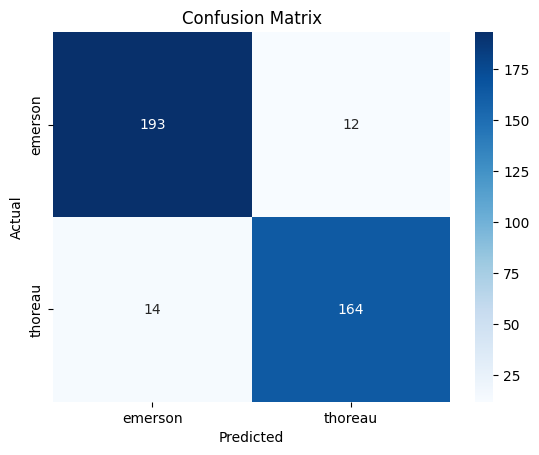

In [61]:
show_metrics(y_test_tok, y_pred, "Logistic Regression on DistilBERT hidden states")

In [62]:
rf = RandomForestClassifier()
rf.fit(x_train_db,y_train_tok)

rf.score(x_test_db,y_test_tok)

y_pred_rf = rf.predict(x_test_db)

# Random Forest on DistilBERT hidden states

              precision    recall  f1-score   support

     emerson       0.82      0.91      0.86       205
     thoreau       0.88      0.77      0.82       178

    accuracy                           0.85       383
   macro avg       0.85      0.84      0.84       383
weighted avg       0.85      0.85      0.84       383

Test accuracy: 0.8459530026109661


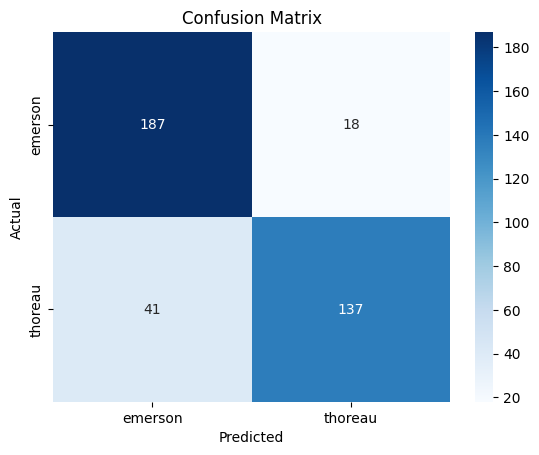

In [63]:
show_metrics(y_test_tok, y_pred_rf, "Random Forest on DistilBERT hidden states")

In [64]:
from sklearn import svm

In [65]:
# create the SVM classifier
clf = svm.SVC(kernel='rbf')

clf.fit(x_train_db,y_train_tok)

y_pred_svm = clf.predict(x_test_db)

# SVM on DistilBERT hidden states

              precision    recall  f1-score   support

     emerson       0.87      0.95      0.90       205
     thoreau       0.93      0.83      0.88       178

    accuracy                           0.89       383
   macro avg       0.90      0.89      0.89       383
weighted avg       0.90      0.89      0.89       383

Test accuracy: 0.8929503916449086


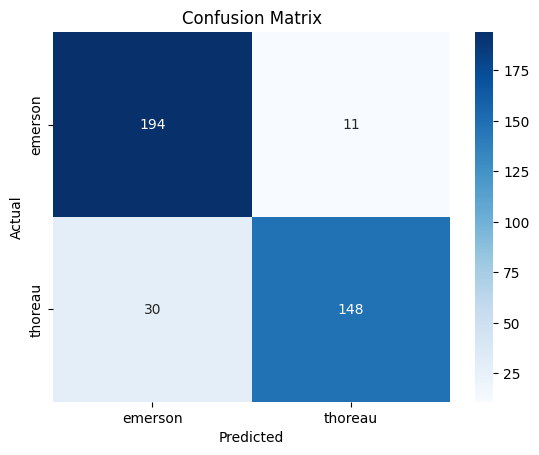

In [66]:
show_metrics(y_test_tok, y_pred_svm, "SVM on DistilBERT hidden states")

In [67]:

from transformers import DistilBertForSequenceClassification

# Define the model with random weights, suitable for binary classification (2 classes)
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased', num_labels=2
)
# we already have the appropriate tokenizer from before.



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [68]:
# create our optimizer
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

In [69]:
!pip install -q datasets

In [70]:
from sklearn import preprocessing

# Create a copy of our dataframe
trans_df = combined_df.copy()

# drop the preprocessed text column which we aren't using.
trans_df.drop("final_text", axis=1, inplace=True)

# transform our labels into numeric values.
le = preprocessing.LabelEncoder()
my_labels = trans_df["label"].tolist()
le.fit(my_labels)

my_cat_labels = le.classes_
trans_df["label"] = le.transform(trans_df["label"])

print(f"{my_cat_labels=}")

trans_df.info()
trans_df.describe()
trans_df.head()


my_cat_labels=array(['emerson', 'thoreau'], dtype='<U7')
<class 'pandas.core.frame.DataFrame'>
Index: 1912 entries, 153 to 77
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1912 non-null   object
 1   label   1912 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 44.8+ KB


,text,label
153,I also dreamed that I might\n\ngather the wild...,1
638,"You admire this tower of granite, weathering t...",0
685,The grass flames up on the\n\nhillsides like a...,1
409,"Money is not\n\nessential, but this wide affin...",0
38,“What!”\n\nexclaimed the Indian as he went out...,1


In [71]:
from datasets import Dataset
from transformers import AutoTokenizer

# for simplicity, we are just splitting the dataset again.
train_df, test_df = train_test_split(trans_df, test_size=0.2, random_state=4909)



train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

def tokenize_data(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_train = train_dataset.map(tokenize_data, batched=True)
tokenized_test = test_dataset.map(tokenize_data, batched=True)

Map:   0%|          | 0/1529 [00:00<?, ? examples/s]

Map:   0%|          | 0/383 [00:00<?, ? examples/s]

In [72]:
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    # this parameter was apparently removed recently.
    # evaluation_strategy="epoch",
    logging_strategy="epoch",
    report_to="none" # prevent prompt to login to W & B
)

# Define Trainer object for training the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

<ipython-input-72-2241263378>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
192,0.342600
384,0.169800
576,0.101700
768,0.086700
960,0.056000


TrainOutput(global_step=960, training_loss=0.15138319631417593, metrics={'train_runtime': 45.8387, 'train_samples_per_second': 166.78, 'train_steps_per_second': 20.943, 'total_flos': 448544702139348.0, 'train_loss': 0.15138319631417593, 'epoch': 5.0})

In [73]:
# Save the model.
trainer.save_model('model')

In [74]:
# This is how you can load the model.

# from transformers import AutoModelForSequenceClassification
# model = AutoModelForSequenceClassification.from_pretrained("./model")

In [75]:
def predictor(text):
  #inputs = tokenizer(text, return_tensors="pt")
  inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
  inputs = {k:torch.tensor(v).to(device) for k,v in inputs.items()}

  with torch.no_grad():
      logits = model(**inputs).logits
  predictions = torch.argmax(logits, dim=-1)
  return predictions


In [76]:
x_test_trans = test_dataset["text"]
y_test_trans = test_dataset["label"]

# sanity test a few inference inputs.
for txt, lbl in zip(x_test_trans[:5], y_test_trans[:5]):
  pred = predictor( txt)
  print(f"{my_cat_labels[lbl]}: pred={my_cat_labels[pred]}, {txt=}")

thoreau: pred=thoreau, txt='But\n\nperchance it would be wisest never to put one’s paw into it.\n\n\n\n I would observe, by the way, that it costs me nothing for curtains, for\n\nI have no gazers to shut out but the sun and moon, and I am willing\n\nthat they should look in. The moon will not sour milk nor taint meat of\n\nmine, nor will the sun injure my furniture or fade my carpet, and if he\n\nis sometimes too warm a friend, I find it still better economy to\n\nretreat behind some curtain which nature has provided, than to add a\n\nsingle item to the details of housekeeping. A lady once offered me a\n\nmat, but as I had no room to spare within the house, nor time to spare\n\nwithin or without to shake it, I declined it, preferring to wipe my\n\nfeet on the sod before my door.'
thoreau: pred=thoreau, txt='This tuber seemed like a faint promise of Nature\n\nto rear her own children and feed them simply here at some future\n\nperiod. In these days of fatted cattle and waving grain-fiel

<ipython-input-75-312163856>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = {k:torch.tensor(v).to(device) for k,v in inputs.items()}


In [77]:
y_pred_trans = [predictor(txt) for txt in x_test_trans]

for txt, lbl, pred in zip(x_test_trans[:5], y_test_trans[:5], y_pred_trans[:5]):
  print(f"{my_cat_labels[lbl]}: pred={my_cat_labels[pred]}, {txt=}")


<ipython-input-75-312163856>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = {k:torch.tensor(v).to(device) for k,v in inputs.items()}


thoreau: pred=thoreau, txt='But\n\nperchance it would be wisest never to put one’s paw into it.\n\n\n\n I would observe, by the way, that it costs me nothing for curtains, for\n\nI have no gazers to shut out but the sun and moon, and I am willing\n\nthat they should look in. The moon will not sour milk nor taint meat of\n\nmine, nor will the sun injure my furniture or fade my carpet, and if he\n\nis sometimes too warm a friend, I find it still better economy to\n\nretreat behind some curtain which nature has provided, than to add a\n\nsingle item to the details of housekeeping. A lady once offered me a\n\nmat, but as I had no room to spare within the house, nor time to spare\n\nwithin or without to shake it, I declined it, preferring to wipe my\n\nfeet on the sod before my door.'
thoreau: pred=thoreau, txt='This tuber seemed like a faint promise of Nature\n\nto rear her own children and feed them simply here at some future\n\nperiod. In these days of fatted cattle and waving grain-fiel

In [78]:
y_pred_trans = [torch.tensor(v).cpu() for v in y_pred_trans]

<ipython-input-78-2635634608>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_trans = [torch.tensor(v).cpu() for v in y_pred_trans]


In [79]:
y_test_trans = [torch.tensor(v).cpu() for v in y_test_trans]

# Fine-tuned DistilBERT

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       197
           1       0.96      0.91      0.93       186

    accuracy                           0.94       383
   macro avg       0.94      0.94      0.94       383
weighted avg       0.94      0.94      0.94       383

Test accuracy: 0.9373368146214099


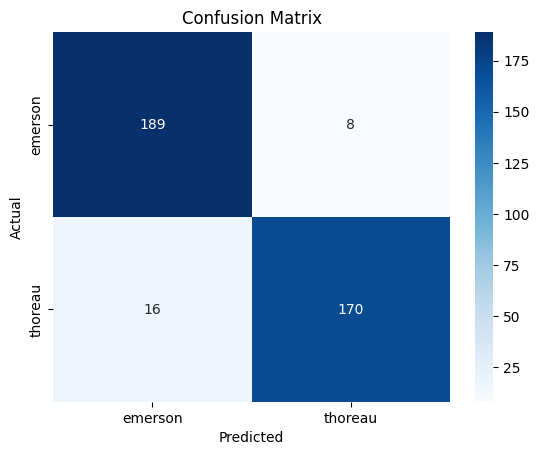

In [80]:
show_metrics(y_pred_trans, y_test_trans, "Fine-tuned DistilBERT")

## Let's check out the test samples that are misclassified.

In [81]:
def scalar_from_tensor(t):
  if t.dim() == 0:
    return t.item()
  elif t.dim() == 1:
    return t[0].item()
  else:
    raise ValueError(f"Unexpected tensor dimension: {t.dim()}")


In [82]:

y_test_trans = [scalar_from_tensor(t) for t in y_test_trans]
y_pred_trans = [scalar_from_tensor(t) for t in y_pred_trans]

print(f"y_test_trans: {y_test_trans[:5]}")
print(f"y_pred_trans: {y_pred_trans[:5]}")


y_test_trans: [1, 1, 0, 1, 1]
y_pred_trans: [1, 1, 0, 1, 1]


In [83]:
print("my_cat_labels")

rows = []
for i, (txt, lbl, pred) in enumerate(zip(x_test_trans, y_test_trans, y_pred_trans)):
  if lbl != pred:
    print(f"{lbl=},{pred=}")
    row =(my_cat_labels[lbl], my_cat_labels[pred], txt)
    print(f"{row=}")
    rows.append(row)

n_miss = len(rows)
print(f"Count of misclassified = {n_miss}")
misclassified_df = pd.DataFrame(rows, columns=["actual", "predicted", "text"])
misclassified_df.head(n_miss)


my_cat_labels
lbl=0,pred=1
row=(np.str_('emerson'), np.str_('thoreau'), 'Wisdom will never let us stand with any man or men on an unfriendly\n\nfooting. We refuse sympathy and intimacy with people, as if we waited\n\nfor some better sympathy and intimacy to come. But whence and when?\n\nTo-morrow will be like to-day. Life wastes itself whilst we are\n\npreparing to live.')
lbl=1,pred=0
row=(np.str_('thoreau'), np.str_('emerson'), 'I will breathe after my own fashion. Let us\n\nsee who is the strongest. What force has a multitude?')
lbl=0,pred=1
row=(np.str_('emerson'), np.str_('thoreau'), 'Project\n\nGutenberg eBooks may be modified and printed and given away—you may\n\ndo practically ANYTHING in the United States with eBooks not protected\n\nby U.S. copyright law. Redistribution is subject to the trademark\n\nlicense, especially commercial redistribution.\n\n\n\n\n\n START: FULL LICENSE\n\n\n\nTHE FULL PROJECT GUTENBERG LICENSE\n\n\n\nPLEASE READ THIS BEFORE YOU DISTRIBUTE OR USE THIS

,actual,predicted,text
0,emerson,thoreau,Wisdom will never let us stand with any man or...
1,thoreau,emerson,I will breathe after my own fashion. Let us\n\...
2,emerson,thoreau,Project\n\nGutenberg eBooks may be modified an...
3,emerson,thoreau,We all know that as the human body\n\ncan be n...
4,emerson,thoreau,"What splendid\n\ndistance, what recesses of in..."
5,thoreau,emerson,The rays\n\nwhich stream through the shutter w...
6,thoreau,emerson,But a man\n\nhas no more to do with the style ...
7,emerson,thoreau,1.F.\n\n\n\n1.F.1. Project Gutenberg volunteer...
8,thoreau,emerson,"As for Doing-good, that is one of the professi..."
9,emerson,thoreau,At\n\nnight he may sleep on a mat under the mo...


## Length distribution of correctly vs incorrectly classified records.

Let's examine the length distribution of correctly and incorrectly classified passages.

In [135]:
# Preprocess a copy of the data to make it friendly to visualization by length, author, and prediction vs actual.

combined_analysis_df = test_df.copy()
combined_analysis_df['predicted_label_numeric'] = y_pred_trans
combined_analysis_df['predicted_label'] = combined_analysis_df['predicted_label_numeric'].map(lambda x: my_cat_labels[x])
combined_analysis_df.head()

combined_analysis_df['correct'] = combined_analysis_df['label'] == combined_analysis_df['predicted_label_numeric']
combined_analysis_df['correct'] = combined_analysis_df['correct'].astype(int)

correctly_classified_mask = combined_analysis_df['correct'] == 1
combined_analysis_df.loc[correctly_classified_mask, 'Classification'] = 'Correctly Classified'
combined_analysis_df.loc[~correctly_classified_mask, 'Classification'] = 'Incorrectly Classified'

combined_analysis_df['label_string'] = combined_analysis_df['label'].map(lambda x: my_cat_labels[x])
combined_analysis_df['label'] = combined_analysis_df['label_string']
combined_analysis_df.drop('label_string', axis=1, inplace=True)
combined_analysis_df.drop('predicted_label_numeric', axis=1, inplace=True)


combined_analysis_df.loc[:, 'word_count'] = combined_analysis_df['text'].apply(lambda x: len(x.split()))
combined_analysis_df.loc[:, 'char_count'] = combined_analysis_df['text'].apply(lambda x: len(x))


combined_analysis_df.head(n=100)

,text,label,text_length,predicted_label,correct,Classification,word_count,char_count
147,But\n\nperchance it would be wisest never to p...,thoreau,147,thoreau,1,Correctly Classified,147,737
542,This tuber seemed like a faint promise of Natu...,thoreau,227,thoreau,1,Correctly Classified,227,1282
242,Let us stun and astonish the intruding rabble ...,emerson,66,emerson,1,Correctly Classified,66,372
77,Morning work! By the blushes of Aurora\n\nand ...,thoreau,91,thoreau,1,Correctly Classified,91,483
501,It comes on apace; my sumachs\n\nand sweet-bri...,thoreau,29,thoreau,1,Correctly Classified,29,161
...,...,...,...,...,...,...,...,...
247,The rays\n\nwhich stream through the shutter w...,thoreau,71,emerson,0,Incorrectly Classified,71,410
334,Let us buy our entrance to this guild by a lon...,emerson,46,emerson,1,Correctly Classified,46,255
498,how far the quadruped! how\n\ninconceivably re...,emerson,19,emerson,1,Correctly Classified,19,112
730,Any truth is better than make-believe. Tom\n\n...,thoreau,47,thoreau,1,Correctly Classified,47,276


In [151]:
def analyze_text_lengths(df, classification_column, label_column, text_column):
  analysis_data = {}
  for classification_outcome in df[classification_column].unique():
      classification_df = df[df[classification_column] == classification_outcome]
      classification_name = classification_outcome # Use the actual outcome name
      analysis_data[classification_name] = {}

      # Overall analysis for the classification outcome
      overall_analysis = {
          'Median Words': classification_df['word_count'].median(),
          'Average Words': classification_df['word_count'].mean(),
          'Median Chars': classification_df['char_count'].median(),
          'Average Chars': classification_df['char_count'].mean()
      }
      analysis_data[classification_name]['all'] = overall_analysis

      # Analysis by author within the classification outcome
      if label_column in classification_df.columns:
          for label_value in classification_df[label_column].unique():
              label_df = classification_df[classification_df[label_column] == label_value]
              author_name = my_cat_labels[label_value] if isinstance(label_value, int) else label_value
              label_analysis = {
                  'Median Words': label_df['word_count'].median(),
                  'Average Words': label_df['word_count'].mean(),
                  'Median Chars': label_df['char_count'].median(),
                  'Average Chars': label_df['char_count'].mean()
              }
              analysis_data[classification_name][author_name] = label_analysis

  # Prepare data for the table
  table_data = []
  index = []
  columns = pd.MultiIndex.from_product([df[classification_column].unique(), ['Words', 'Chars']], names=['Classification', 'Count Type'])

  # Add 'all' row first
  row_data_all = {}
  for classification_outcome in df[classification_column].unique():
        classification_name = classification_outcome
        row_data_all[(classification_name, 'Words')] = f"{analysis_data[classification_name]['all']['Median Words']:.2f}/{analysis_data[classification_name]['all']['Average Words']:.2f}"
        row_data_all[(classification_name, 'Chars')] = f"{analysis_data[classification_name]['all']['Median Chars']:.2f}/{analysis_data[classification_name]['all']['Average Chars']:.2f}"
  table_data.append(row_data_all)
  index.append('all')

  # Add rows for each author
  for author_name in ['thoreau', 'emerson']: # Explicitly defined for consistent order
      row_data_author = {}
      for classification_outcome in df[classification_column].unique():
          classification_name = classification_outcome
          if author_name in analysis_data[classification_name]:
              row_data_author[(classification_name, 'Words')] = f"{analysis_data[classification_name][author_name]['Median Words']:.2f}/{analysis_data[classification_name][author_name]['Average Words']:.2f}"
              row_data_author[(classification_name, 'Chars')] = f"{analysis_data[classification_name][author_name]['Median Chars']:.2f}/{analysis_data[classification_name][author_name]['Average Chars']:.2f}"
          else: # Handle missing author.
                row_data_author[(classification_name, 'Words')] = "N/A"
                row_data_author[(classification_name, 'Chars')] = "N/A"

      table_data.append(row_data_author)
      index.append(author_name)

  analysis_table = pd.DataFrame(table_data, index=index, columns=columns)

  # Split by chars and words.
  word_count_table = analysis_table.iloc[:, analysis_table.columns.get_level_values(1) == 'Words'].copy()
  char_count_table = analysis_table.iloc[:, analysis_table.columns.get_level_values(1) == 'Chars'].copy()

  print("\nWord Count (Median/Average):")
  display(word_count_table)

  print("\nCharacter Count (Median/Average):")
  display(char_count_table)



In [152]:
def plot_text_length_density(df, classification_column, label_column, text_column):
  # Density plot for Word Count
  g = sns.FacetGrid(df, col=classification_column, hue=label_column, palette='viridis', sharey=False, height=5, aspect=0.9)
  g.map(sns.kdeplot, 'word_count', fill=True, alpha=0.5)
  g.add_legend(title='Author')
  g.fig.suptitle('Density of Word Count by Classification Outcome and Author', y=1.02)
  g.set_axis_labels("Number of Words", "Density")
  g.set_titles("{col_name}")
  plt.show()

  # Density plot for Character Count
  g = sns.FacetGrid(df, col=classification_column, hue=label_column, palette='viridis', sharey=False, height=5, aspect=0.9)
  g.map(sns.kdeplot, 'char_count', fill=True, alpha=0.5)
  g.add_legend(title='Author')
  g.fig.suptitle('Density of Character Count by Classification Outcome and Author', y=1.02)
  g.set_axis_labels("Number of Characters", "Density")
  g.set_titles("{col_name}")
  plt.show()

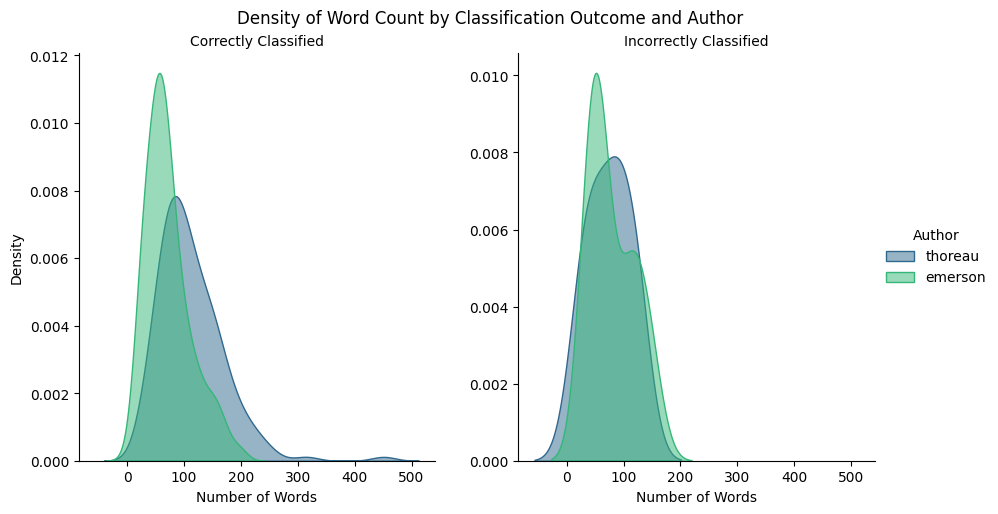

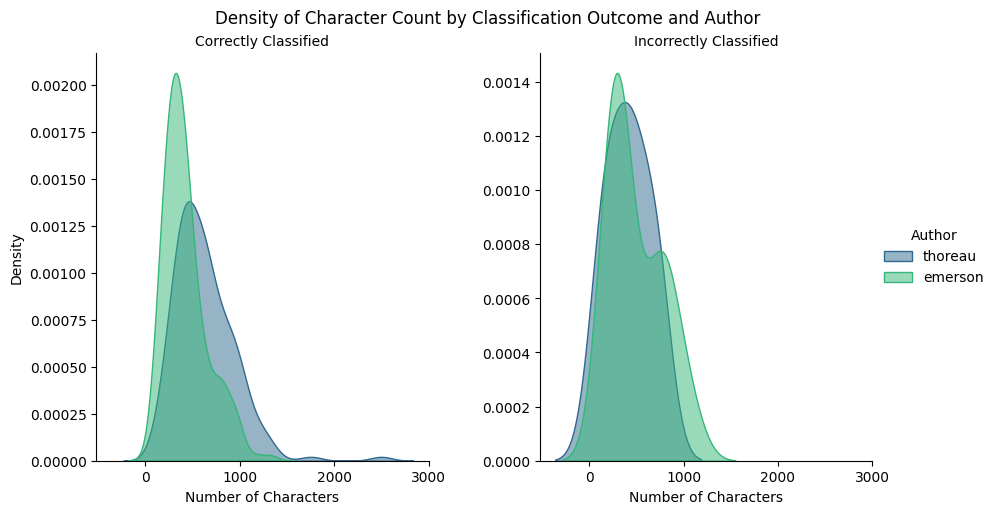

In [153]:
plot_text_length_density(combined_analysis_df.copy(), 'Classification', 'label', 'text')

In [154]:
analyze_text_lengths(combined_analysis_df.copy(), 'Classification', 'label', 'text')


Word Count (Median/Average):


Classification,Correctly Classified,Incorrectly Classified
Count Type,Words,Words
all,78.00/90.59,68.50/77.50
thoreau,100.00/111.79,78.50/74.38
emerson,62.00/71.52,65.50/79.06



Character Count (Median/Average):


Classification,Correctly Classified,Incorrectly Classified
Count Type,Chars,Chars
all,445.00/517.40,403.50/467.54
thoreau,577.00/623.26,417.00/413.88
emerson,372.00/422.19,364.50/494.38
